In [2]:
import sys ; sys.path.append('../')
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

In [3]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')

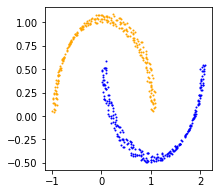

In [4]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue']
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

In [5]:
import torch
import torch.utils.data as data
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

In [6]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [7]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )

In [8]:
model = NeuralDE(f, sensitivity='adjoint', solver='dopri5').to(device)


In [9]:
learn = Learner(model)
trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/dhsung/anaconda3/envs/general/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 82    
-----------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)
Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, loss=1.11, v_num=0]/home/dhsung/anaconda3/envs/general/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataL

In [10]:
s_span = torch.linspace(0,1,100)
trajectory = model.trajectory(X_train, s_span).detach().cpu()

Text(0.5, 1.0, 'Dimension 1')

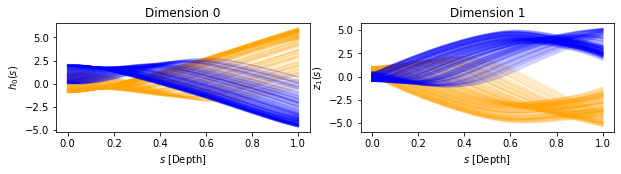

In [11]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(s_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(s_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$s$ [Depth]") ; ax0.set_ylabel(r"$h_0(s)$")
ax1.set_xlabel(r"$s$ [Depth]") ; ax1.set_ylabel(r"$z_1(s)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

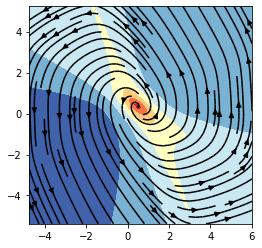

In [12]:
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = model.defunc(0,z.to(device)).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')